# Test models with geodata clustered in k-means

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import uuid

In [16]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

## Processing functions

In [17]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [18]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer=opt)
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])
    _, k_area = series_split_sequences(test, test['k_area'], n_steps_in, n_steps_out)

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, train_true = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    _, k_area_train = series_split_sequences(train, train['k_area'], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, train_true)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_true, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test[[target_feature]])
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train[[target_feature]])
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_true': train_true,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1],
               'k_area': k_area,
               'k_area_train': k_area_train
               }

    return results

def plot_lstm_1_step(pred, true, colors:list, target_feature:str, operator:str, feature_comb:str, test_train:str):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(pred, label='Predicted', color=colors[0], zorder=2)
    true = plt.plot(true, label='True', color=colors[2], zorder=1)
    plt.xlabel('Index / Timestamp')
    plt.ylabel(target_feature)
    plt.xlim((0, 200))
    plt.title(f'Prediction on {test_train} data\n{operator}\nCombination of training features: {feature_comb}')
    plt.legend(handles=[pred[0], true[0]])
    plt.show()

    return fig

'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_in:int, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 16), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_in} steps in, {n_steps_out} steps out\n{operator}', fontsize=18, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    fig.subplots_adjust(wspace=0.5, hspace=10)

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

## Random Forest functions

In [19]:
def rf(X_train, X_test, mode_train, mode_test, campaigns:list, test_campaigns:list, features:list, n_steps_in:int, n_steps_out:int, n_estimators=100, max_depth=None, min_samples_leaf=1, preds=[], train_preds__=[]):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(preds) == 0 and len(train_preds__) == 0:
        preds_pred = None
        train_preds_pred = None
        if len(test_campaigns) == 1:
            y_pred = rf.predict(X_test[features])

            accuracy = accuracy_score(mode_test['Mode'], y_pred)
            precision = precision_score(mode_test['Mode'], y_pred)
            recall = recall_score(mode_test['Mode'], y_pred)

            y_true = mode_test['Mode']

            train_pred = rf.predict(X_train[features])

            train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
            train_precision = precision_score(mode_train['Mode'], train_pred)
            train_recall = recall_score(mode_train['Mode'], train_pred)

            train_true = mode_train['Mode']
        else:
            X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
            X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
            
            y_pred = rf.predict(X_test_test[features])

            y_pred_total = rf.predict(X_test[features])
            accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
            precision = precision_score(mode_test['Mode'], y_pred_total)
            recall = recall_score(mode_test['Mode'], y_pred_total)

            y_true = X_test_mode['Mode']

            X_train_test = X_train[X_train['campaign'] == campaigns[0]]
            X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

            train_pred = rf.predict(X_train_test[features])

            train_pred_total = rf.predict(X_train[features])
            train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
            train_precision = precision_score(mode_train['Mode'], train_pred_total)
            train_recall = recall_score(mode_train['Mode'], train_pred_total)

            train_true = X_train_mode['Mode']

        pred_accuracy, pred_recall, pred_precision = 0, 0, 0
        train_pred_accuracy, train_pred_recall, train_pred_precision = 0, 0, 0

    else:
        _, y_true = series_split_sequences(X_test, mode_test['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, test_seq = series_split_sequences(X_test, X_test[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_true = series_split_sequences(X_train, mode_train['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_seq = series_split_sequences(X_train, X_train[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        y_pred = []
        preds_pred = []
        train_preds = []
        train_preds_pred = []

        for i in range(len(test_seq)):
            pred = rf.predict(test_seq[i])
            y_pred.append(pred)
        
        for i in range(len(preds)):
            row = preds.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            preds_pred.append(pred)

        for i in range(len(train_seq)):
            pred = rf.predict(train_seq[i])
            train_preds.append(pred)
        
        for i in range(len(train_preds__)):
            row = train_preds__.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            train_preds_pred.append(pred)
        
        accuracy, recall, precision = metrics(y_true, y_pred)
        train_accuracy, train_recall, train_precision = metrics(train_true, train_preds)
        pred_accuracy, pred_recall, pred_precision = metrics(y_true, preds_pred)
        train_pred_accuracy, train_pred_recall, train_pred_precision = metrics(train_true, train_preds_pred)
    
    acc, train_acc = [], []

    if n_steps_out > 1:
        for i in range(n_steps_out):
            acc.append(accuracy_score(np.array(y_true)[:, i], np.array(y_pred)[:, i]))
            train_acc.append(accuracy_score(np.array(train_true)[:, i], np.array(train_preds)[:, i]))

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'pred_pred': preds_pred,
               'train_true': train_true,
               'train_pred': train_preds,
               'train_pred_pred':  train_preds_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_pred': round(pred_accuracy, 3),
               'Precision_pred': round(pred_recall, 3),
               'Recall_pred': round(pred_precision, 3),
               'Accuracy_train_pred': round(train_pred_accuracy, 3),
               'Recall_train_pred': round(train_pred_recall, 3),
               'Precision_train_pred': round(train_pred_precision, 3),
               'model': rf,
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }
    return results

def plot_mode(pred, true, preds, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(preds, color=colors[0], label='Predicted on predicted values', zorder=1)
    plt.plot(np.array(pred) + 2, color=colors[1], label='Predicted on true values', zorder=2)
    plt.plot(np.array(true) + 4, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 6))
    plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.show()
    return fig

In [20]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [21]:
overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
           'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
           'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

df = read_dataset(dataset, campaigns=overlap[0:3])

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap[3]])
df = pd.concat([route_to_add[5350::], df])
df.reset_index(drop=True, inplace=True)

df['ID'] = [str(uuid.uuid4()) for _ in range(len(df))]
X = df.loc[:, ['ID','Latitude','Longitude']]

## K-means of geodata

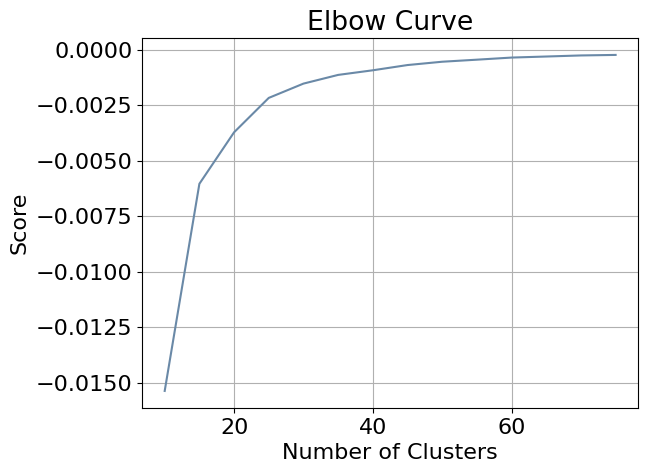

In [22]:
k_clusters = range(10, 80, 5)
kmeans = [KMeans(n_clusters=i) for i in k_clusters]

y_axis = df[['Latitude']]
X_axis = df[['Longitude']]

score = [kmeans[i].fit(y_axis).score(y_axis) for i in range(len(kmeans))]

plt.plot(k_clusters, score, color=rsrp_colors[1], zorder=2)
plt.grid(zorder=1)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

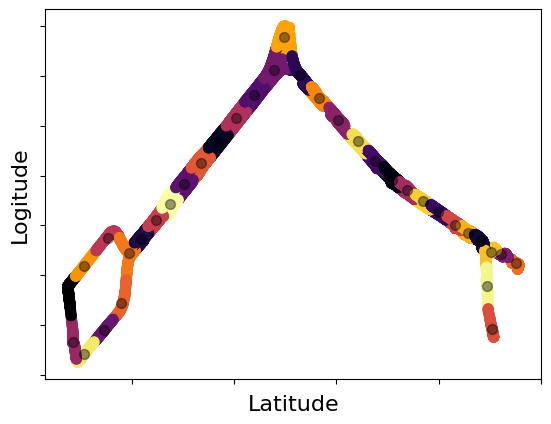

In [23]:
kmeans = KMeans(n_clusters=35, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op2_map_35_clusters_kmeans.pdf')

In [24]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,27
1,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,27
2,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,27
3,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,27
4,-107.06,4.83,-17.18,-116.8,-2.8,-15.0,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,27
...,...,...,...,...,...,...,...,...,...
10328,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,3
10329,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,3
10330,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,3
10331,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,3


In [25]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

## LSTM

### 1 step ahead

In [26]:
units = [10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [27]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [28]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00228,0.00050,0.62,0.52
1,"RSRP, SINR -> RSRP",0.00288,0.00088,0.65,0.60
2,"RSRP, RSRQ -> RSRP",0.00304,0.00071,0.74,0.68
3,"RSRP, SINR, RSRQ -> RSRP",0.00272,0.00090,1.03,1.00
4,"RSRP, SSS_RSRP -> RSRP",0.00244,0.00059,0.83,0.76
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00218,0.00058,0.69,0.68
6,SINR -> SINR,0.00155,0.00135,0.59,0.59
7,"RSRP, SINR -> SINR",0.00180,0.00132,0.55,0.55
8,"SINR, RSRQ -> SINR",0.00165,0.00147,0.57,0.61
9,"RSRP, SINR, RSRQ -> SINR",0.00162,0.00312,0.70,0.79


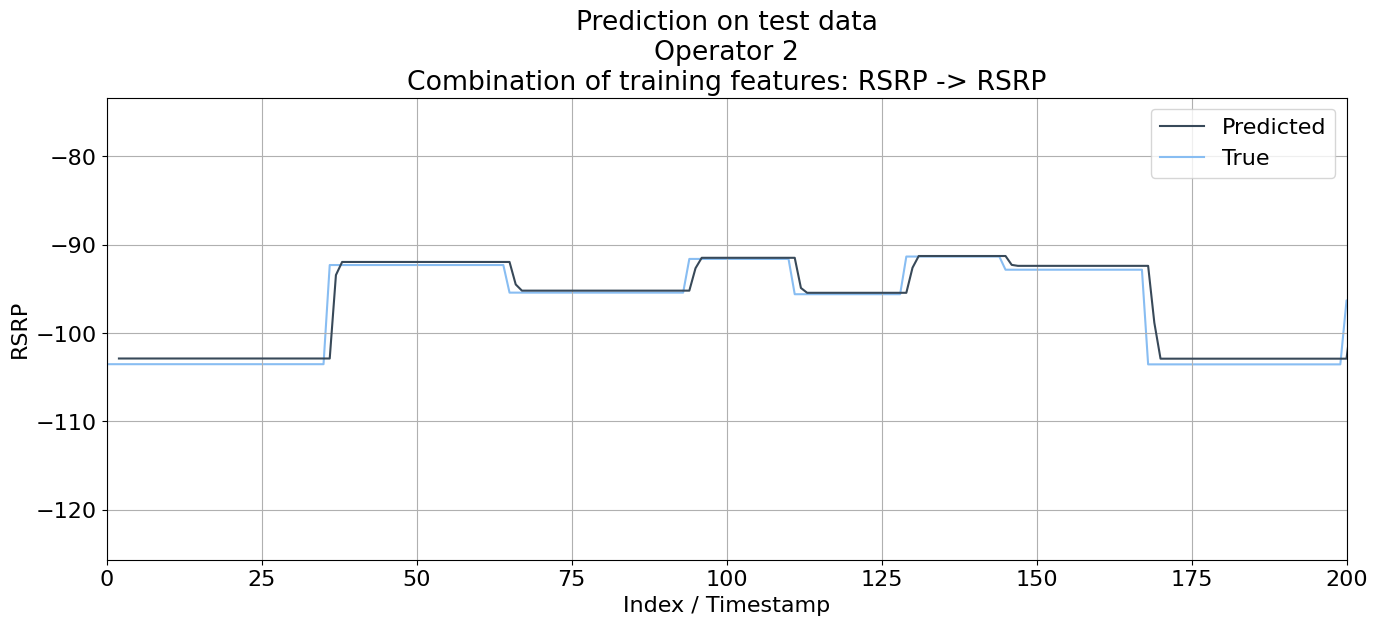

In [29]:
selected_rsrp_comb = 'RSRP -> RSRP'
rsrp_comb = lstm_results_1_step[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred_plot']
rsrp_true = rsrp_comb['y_true_plot']
rsrp_train_pred = rsrp_comb['train_pred_plot']
rsrp_train_true = rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrp_pred, true=rsrp_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='test')

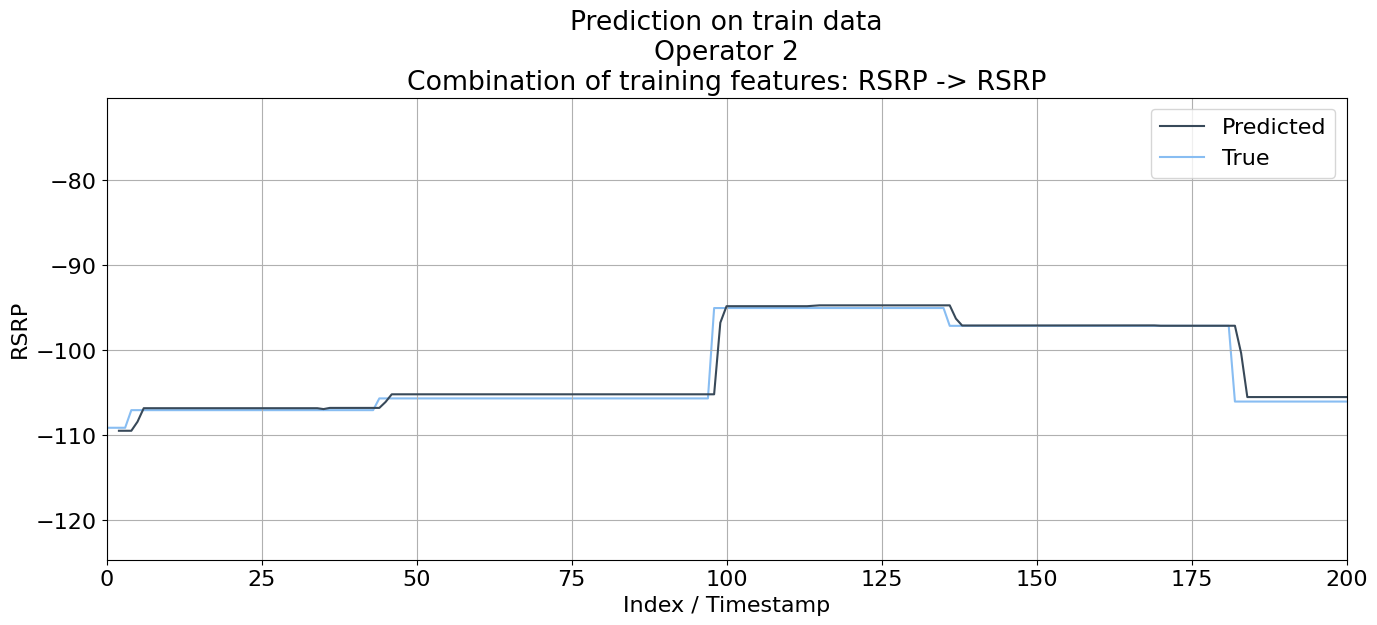

In [30]:
fig = plot_lstm_1_step(pred=rsrp_train_pred, true=rsrp_train_true, colors=rsrp_colors, target_feature='RSRP', operator=operator, feature_comb=selected_rsrp_comb, test_train='train')

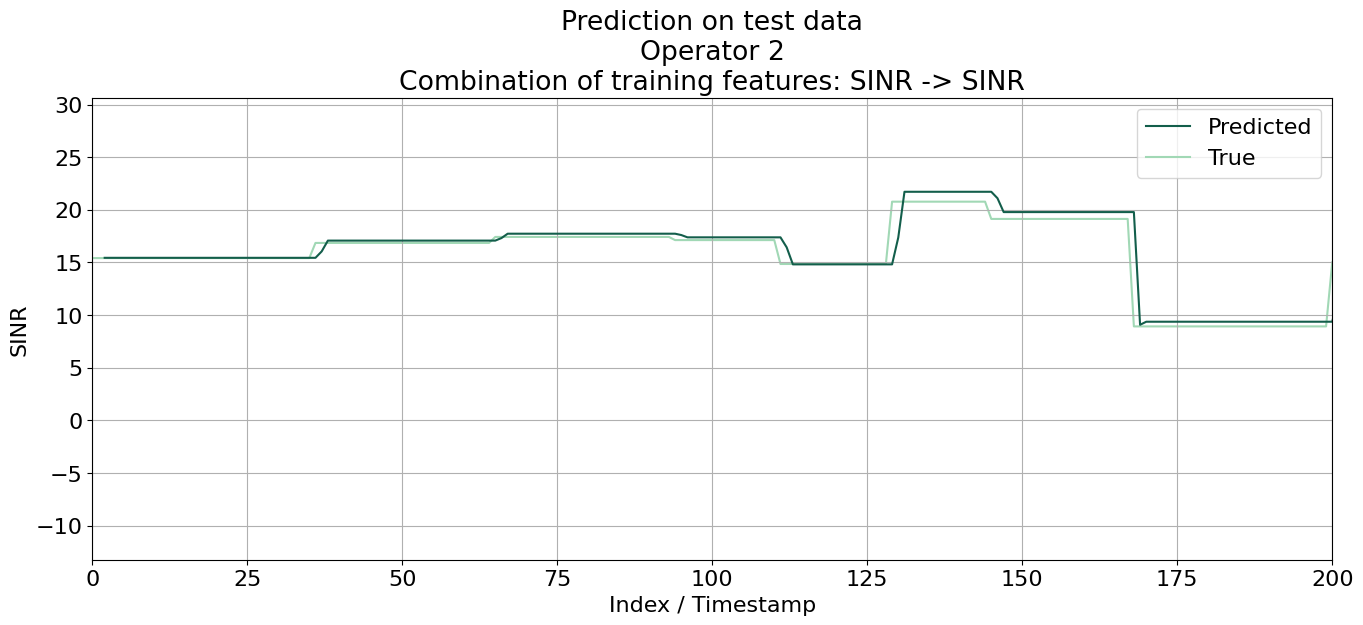

In [31]:
selected_sinr_comb = 'SINR -> SINR'
sinr_comb = lstm_results_1_step[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred_plot']
sinr_true = sinr_comb['y_true_plot']
sinr_train_pred = sinr_comb['train_pred_plot']
sinr_train_true = sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sinr_pred, true=sinr_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='test')

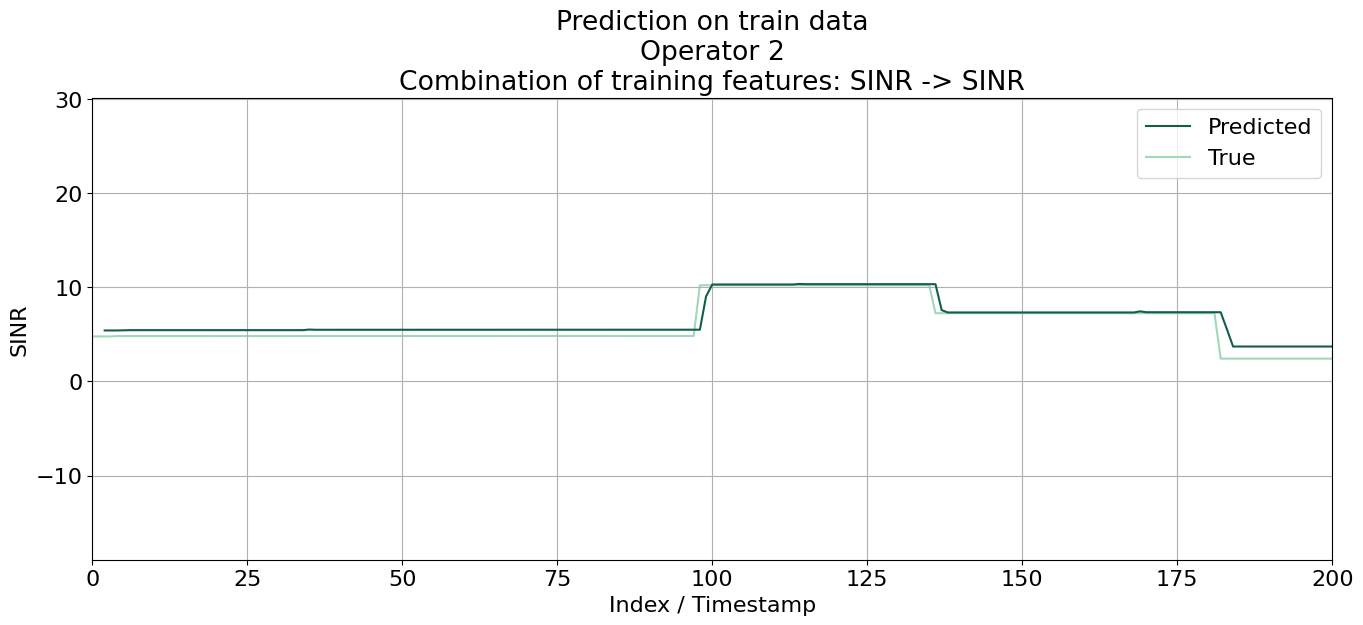

In [32]:
fig = plot_lstm_1_step(pred=sinr_train_pred, true=sinr_train_true, colors=sinr_colors, target_feature='SINR', operator=operator, feature_comb=selected_sinr_comb, test_train='train')

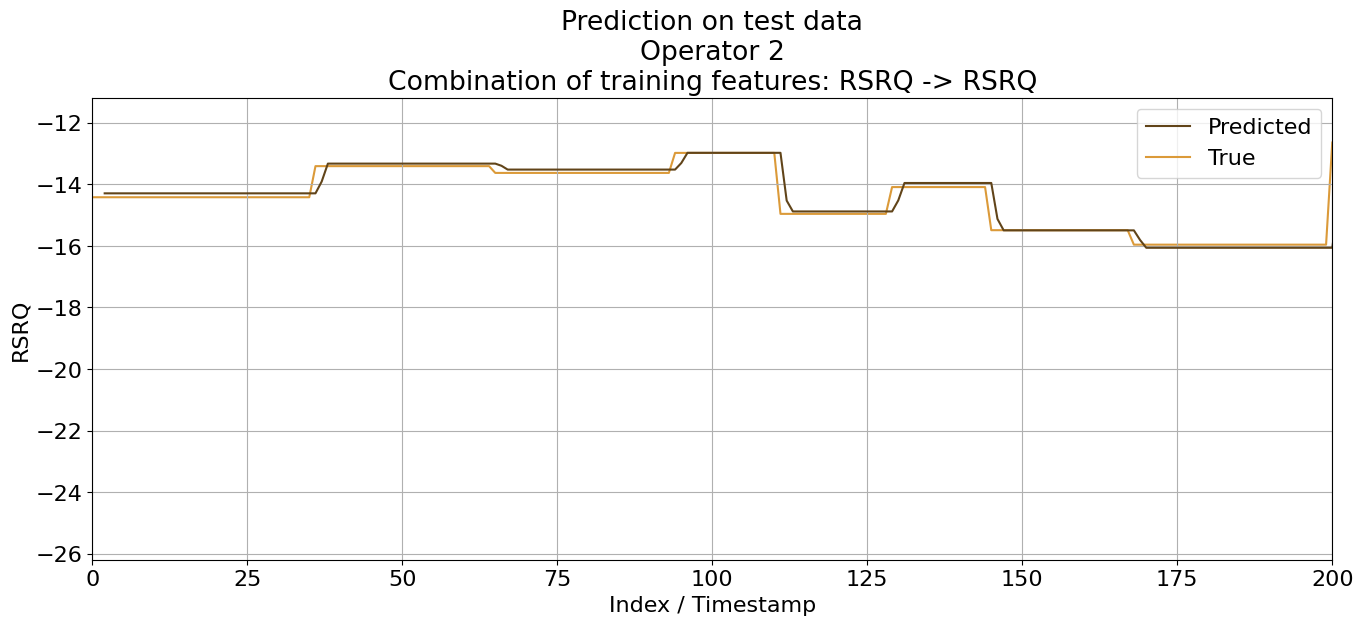

In [33]:
selected_rsrq_comb = 'RSRQ -> RSRQ'
rsrq_comb = lstm_results_1_step[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred_plot']
rsrq_true = rsrq_comb['y_true_plot']
rsrq_train_pred = rsrq_comb['train_pred_plot']
rsrq_train_true = rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=rsrq_pred, true=rsrq_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='test')

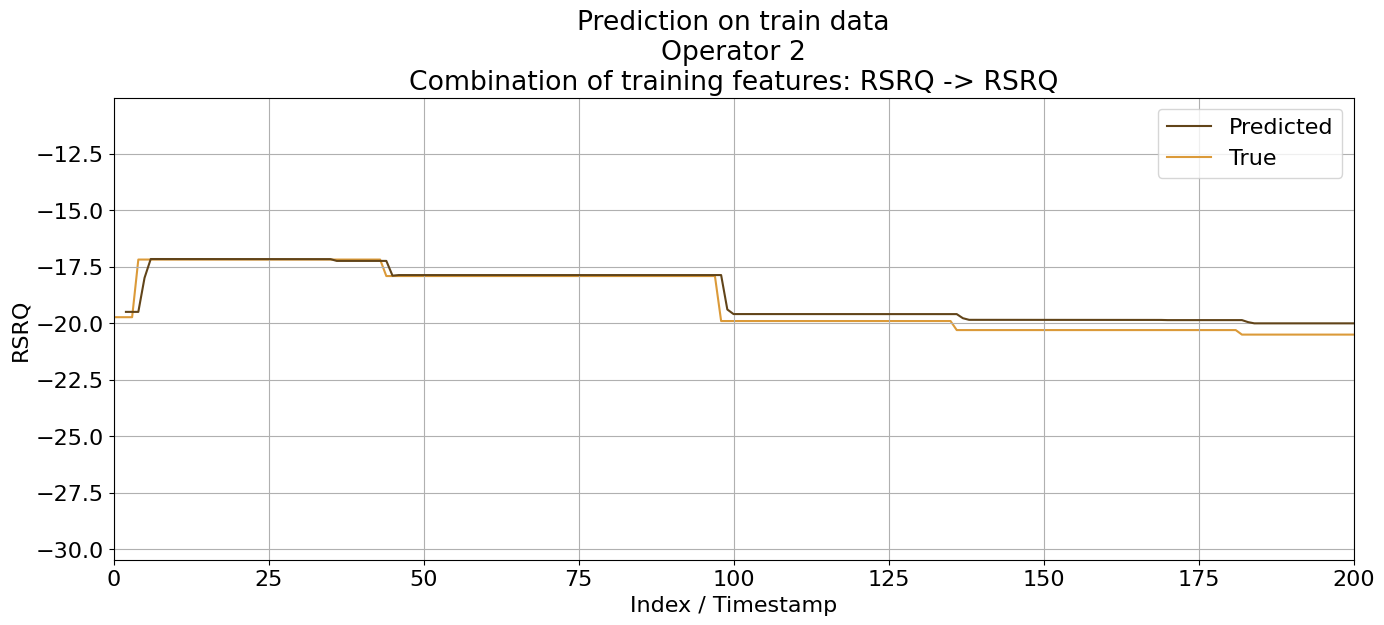

In [34]:
fig = plot_lstm_1_step(pred=rsrq_train_pred, true=rsrq_train_true, colors=rsrq_colors, target_feature='RSRQ', operator=operator, feature_comb=selected_rsrq_comb, test_train='train')

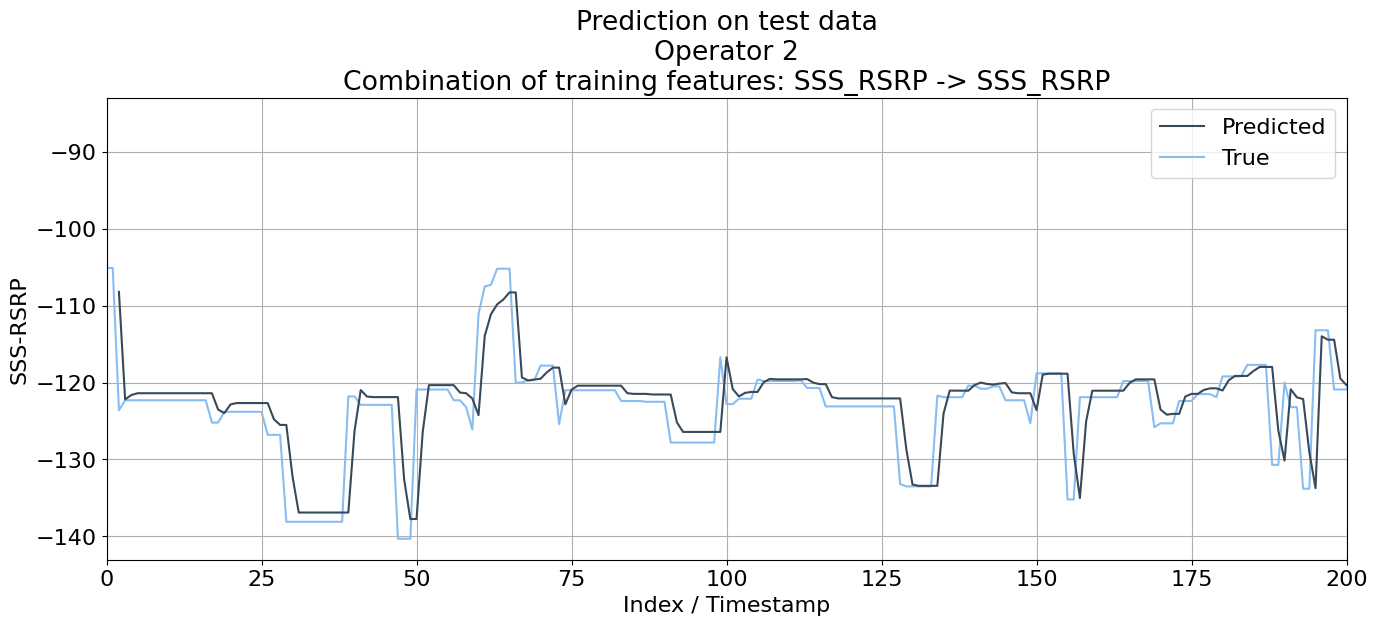

In [35]:
selected_sss_rsrp_comb = 'SSS_RSRP -> SSS_RSRP'
sss_rsrp_comb = lstm_results_1_step[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred_plot']
sss_rsrp_true = sss_rsrp_comb['y_true_plot']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred_plot']
sss_rsrp_train_true = sss_rsrp_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrp_pred, true=sss_rsrp_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='test')

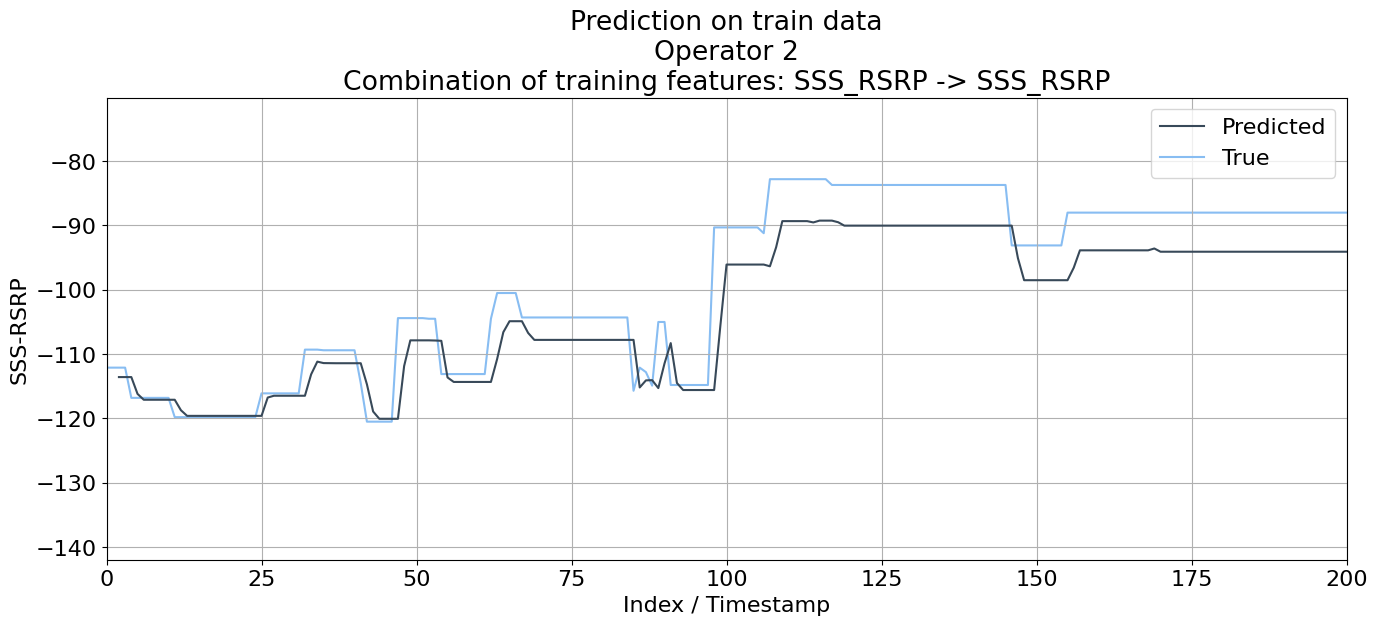

In [36]:
fig = plot_lstm_1_step(pred=sss_rsrp_train_pred, true=sss_rsrp_train_true, colors=rsrp_colors, target_feature='SSS-RSRP', operator=operator, feature_comb=selected_sss_rsrp_comb, test_train='train')

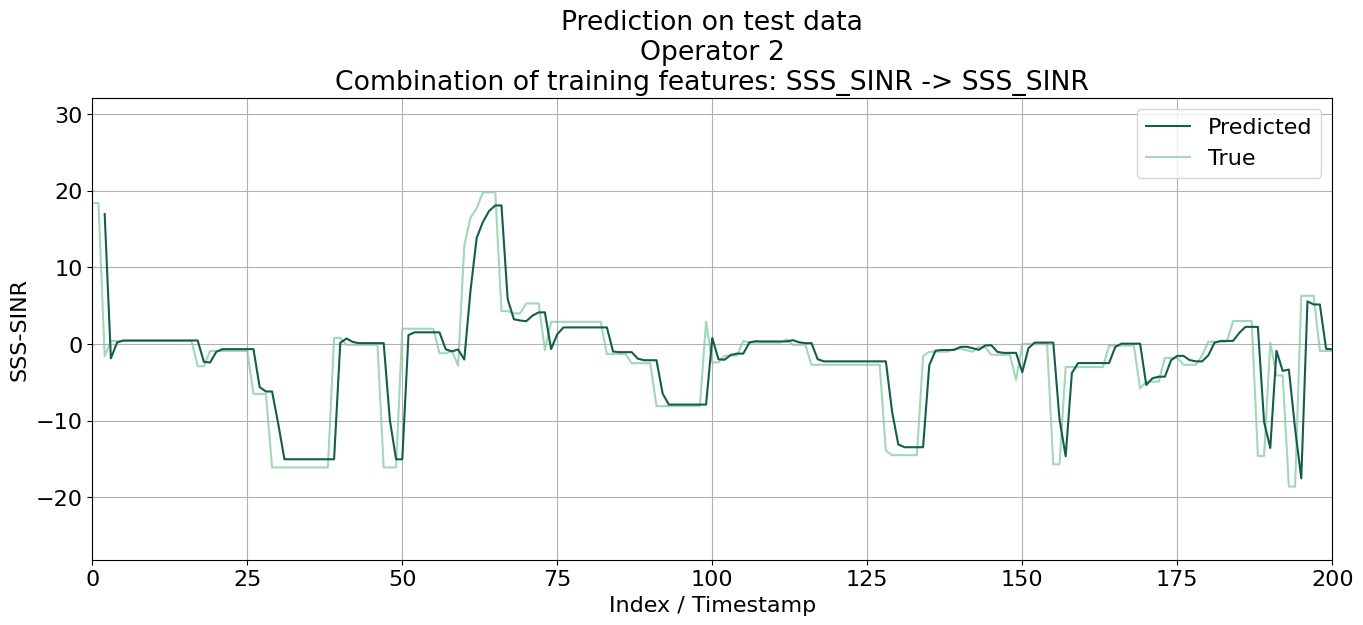

In [37]:
selected_sss_sinr_comb = 'SSS_SINR -> SSS_SINR'
sss_sinr_comb = lstm_results_1_step[selected_sss_sinr_comb]
sss_sinr_pred = sss_sinr_comb['y_pred_plot']
sss_sinr_true = sss_sinr_comb['y_true_plot']
sss_sinr_train_pred = sss_sinr_comb['train_pred_plot']
sss_sinr_train_true = sss_sinr_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_sinr_pred, true=sss_sinr_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='test')

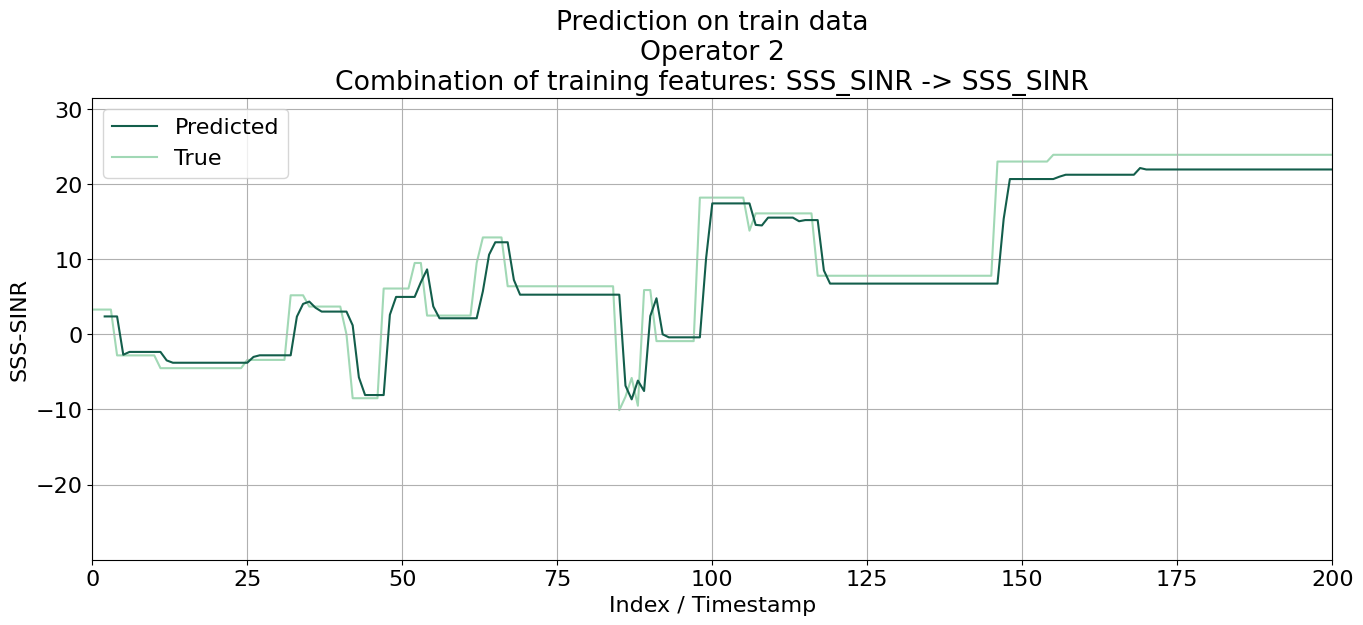

In [38]:
fig = plot_lstm_1_step(pred=sss_sinr_train_pred, true=sss_sinr_train_true, colors=sinr_colors, target_feature='SSS-SINR', operator=operator, feature_comb=selected_sss_sinr_comb, test_train='train')

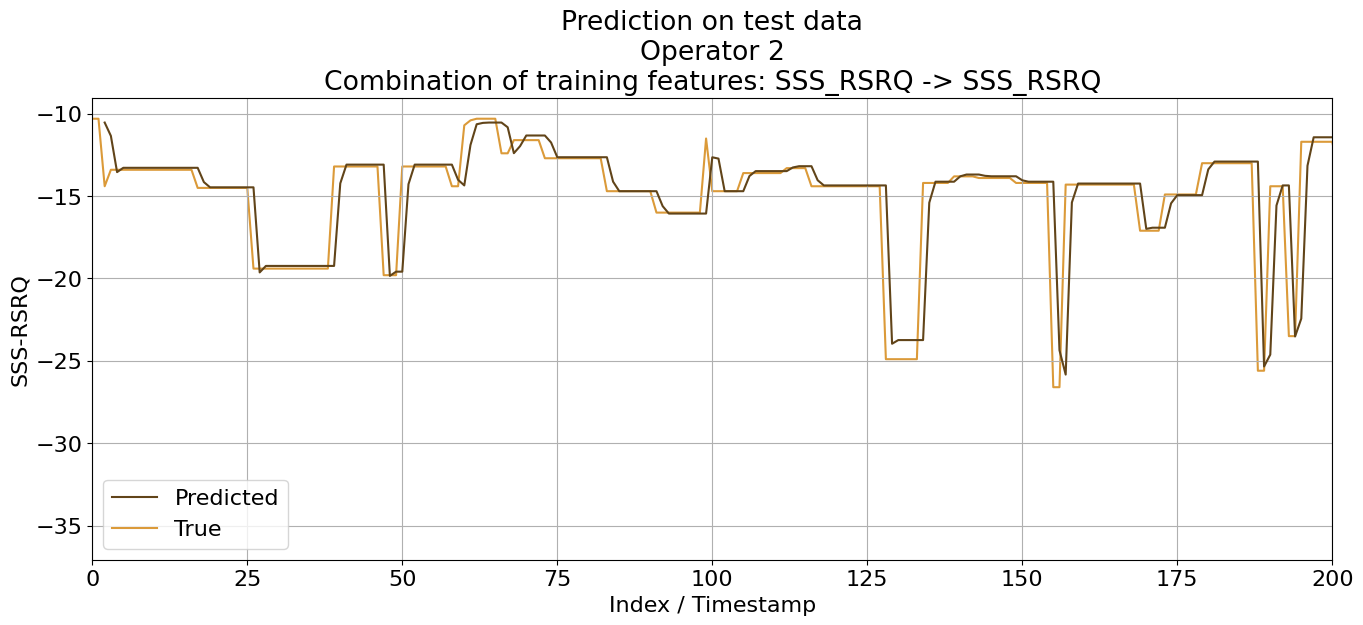

In [39]:
selected_sss_rsrq_comb = 'SSS_RSRQ -> SSS_RSRQ'
sss_rsrq_comb = lstm_results_1_step[selected_sss_rsrq_comb]
sss_rsrq_pred = sss_rsrq_comb['y_pred_plot']
sss_rsrq_true = sss_rsrq_comb['y_true_plot']
sss_rsrq_train_pred = sss_rsrq_comb['train_pred_plot']
sss_rsrq_train_true = sss_rsrq_comb['train_true_plot']

fig = plot_lstm_1_step(pred=sss_rsrq_pred, true=sss_rsrq_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

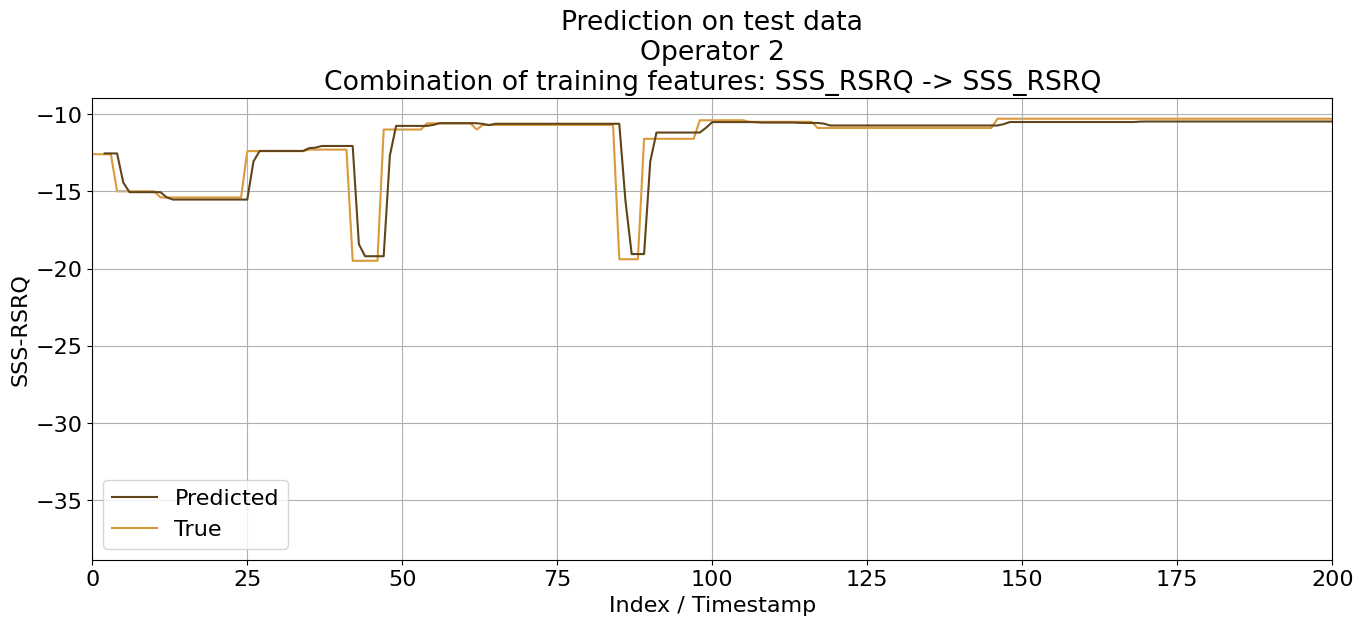

In [40]:
fig = plot_lstm_1_step(pred=sss_rsrq_train_pred, true=sss_rsrq_train_true, colors=rsrq_colors, target_feature='SSS-RSRQ', operator=operator, feature_comb=selected_sss_rsrq_comb, test_train='test')

In [41]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [42]:
n_est, leaf = 50, 5

In [43]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]
warnings.simplefilter(action='ignore')
rf_results[f'n_est: {n_est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=n_est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 50, min_leaf: 5",0.68,0.898,0.589,0.997,0.997,0.997,0.67,0.592,0.874,0.97,0.958,0.977


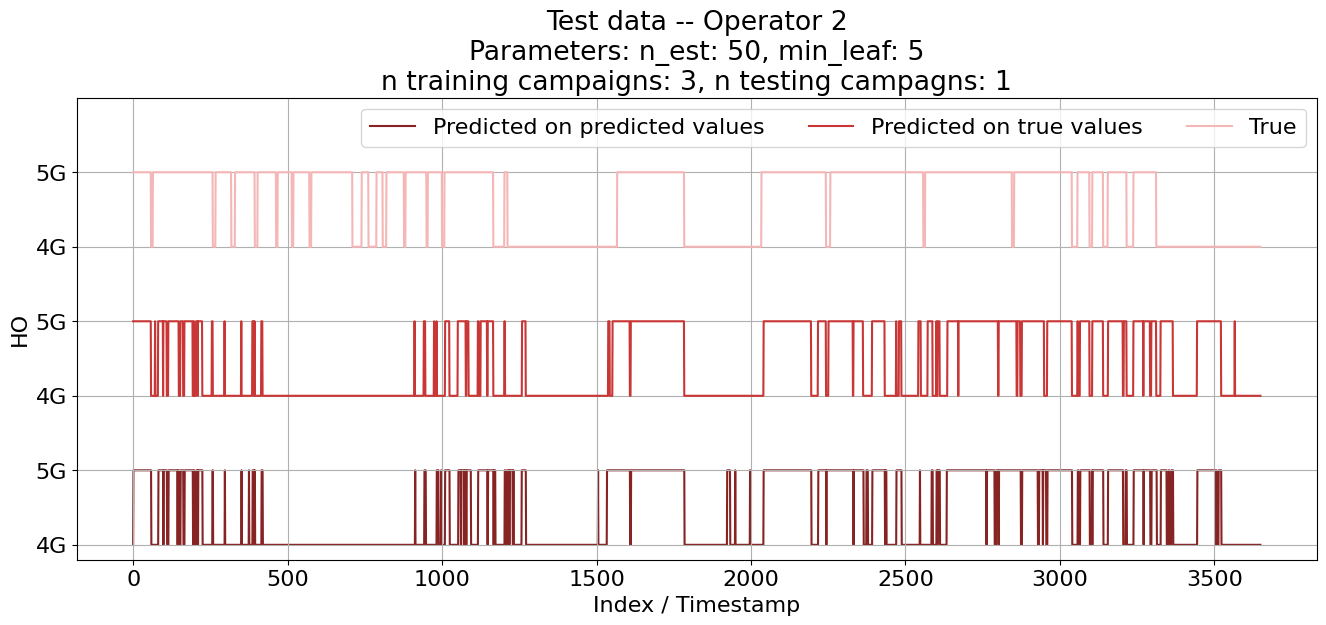

In [44]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

In [45]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [46]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred
0,"n_est: 5, min_leaf: 1",0.642,0.892,0.530,0.998,0.998,0.998,0.631,0.531,0.866,0.945,0.927,0.955
1,"n_est: 5, min_leaf: 5",0.698,0.889,0.628,0.995,0.994,0.996,0.679,0.628,0.855,0.948,0.934,0.956
2,"n_est: 5, min_leaf: 10",0.673,0.902,0.574,0.990,0.986,0.992,0.657,0.573,0.871,0.936,0.927,0.936
3,"n_est: 5, min_leaf: 15",0.655,0.872,0.567,0.989,0.987,0.989,0.626,0.546,0.839,0.932,0.910,0.945
4,"n_est: 10, min_leaf: 1",0.635,0.899,0.512,0.999,0.999,0.999,0.610,0.486,0.875,0.947,0.915,0.972
5,"n_est: 10, min_leaf: 5",0.688,0.884,0.616,0.996,0.997,0.996,0.662,0.583,0.868,0.964,0.954,0.969
6,"n_est: 10, min_leaf: 10",0.694,0.899,0.611,0.991,0.986,0.995,0.673,0.599,0.873,0.954,0.952,0.950
7,"n_est: 10, min_leaf: 15",0.683,0.899,0.593,0.989,0.986,0.991,0.676,0.600,0.878,0.958,0.950,0.960
8,"n_est: 50, min_leaf: 1",0.681,0.908,0.582,0.999,0.999,0.999,0.663,0.567,0.889,0.978,0.970,0.982
9,"n_est: 50, min_leaf: 5",0.680,0.898,0.589,0.997,0.997,0.996,0.652,0.564,0.870,0.976,0.971,0.979


In [47]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.683
Mean precision: 0.903
Mean recall: 0.590


In [48]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [49]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00228,0.00050,0.62,0.52
1,"RSRP, SINR -> RSRP",0.00288,0.00088,0.65,0.60
2,"RSRP, RSRQ -> RSRP",0.00304,0.00071,0.74,0.68
3,"RSRP, SINR, RSRQ -> RSRP",0.00272,0.00090,1.03,1.00
4,"RSRP, SSS_RSRP -> RSRP",0.00244,0.00059,0.83,0.76
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00218,0.00058,0.69,0.68
6,SINR -> SINR,0.00155,0.00135,0.59,0.59
7,"RSRP, SINR -> SINR",0.00180,0.00132,0.55,0.55
8,"SINR, RSRQ -> SINR",0.00165,0.00147,0.57,0.61
9,"RSRP, SINR, RSRQ -> SINR",0.00162,0.00312,0.70,0.79


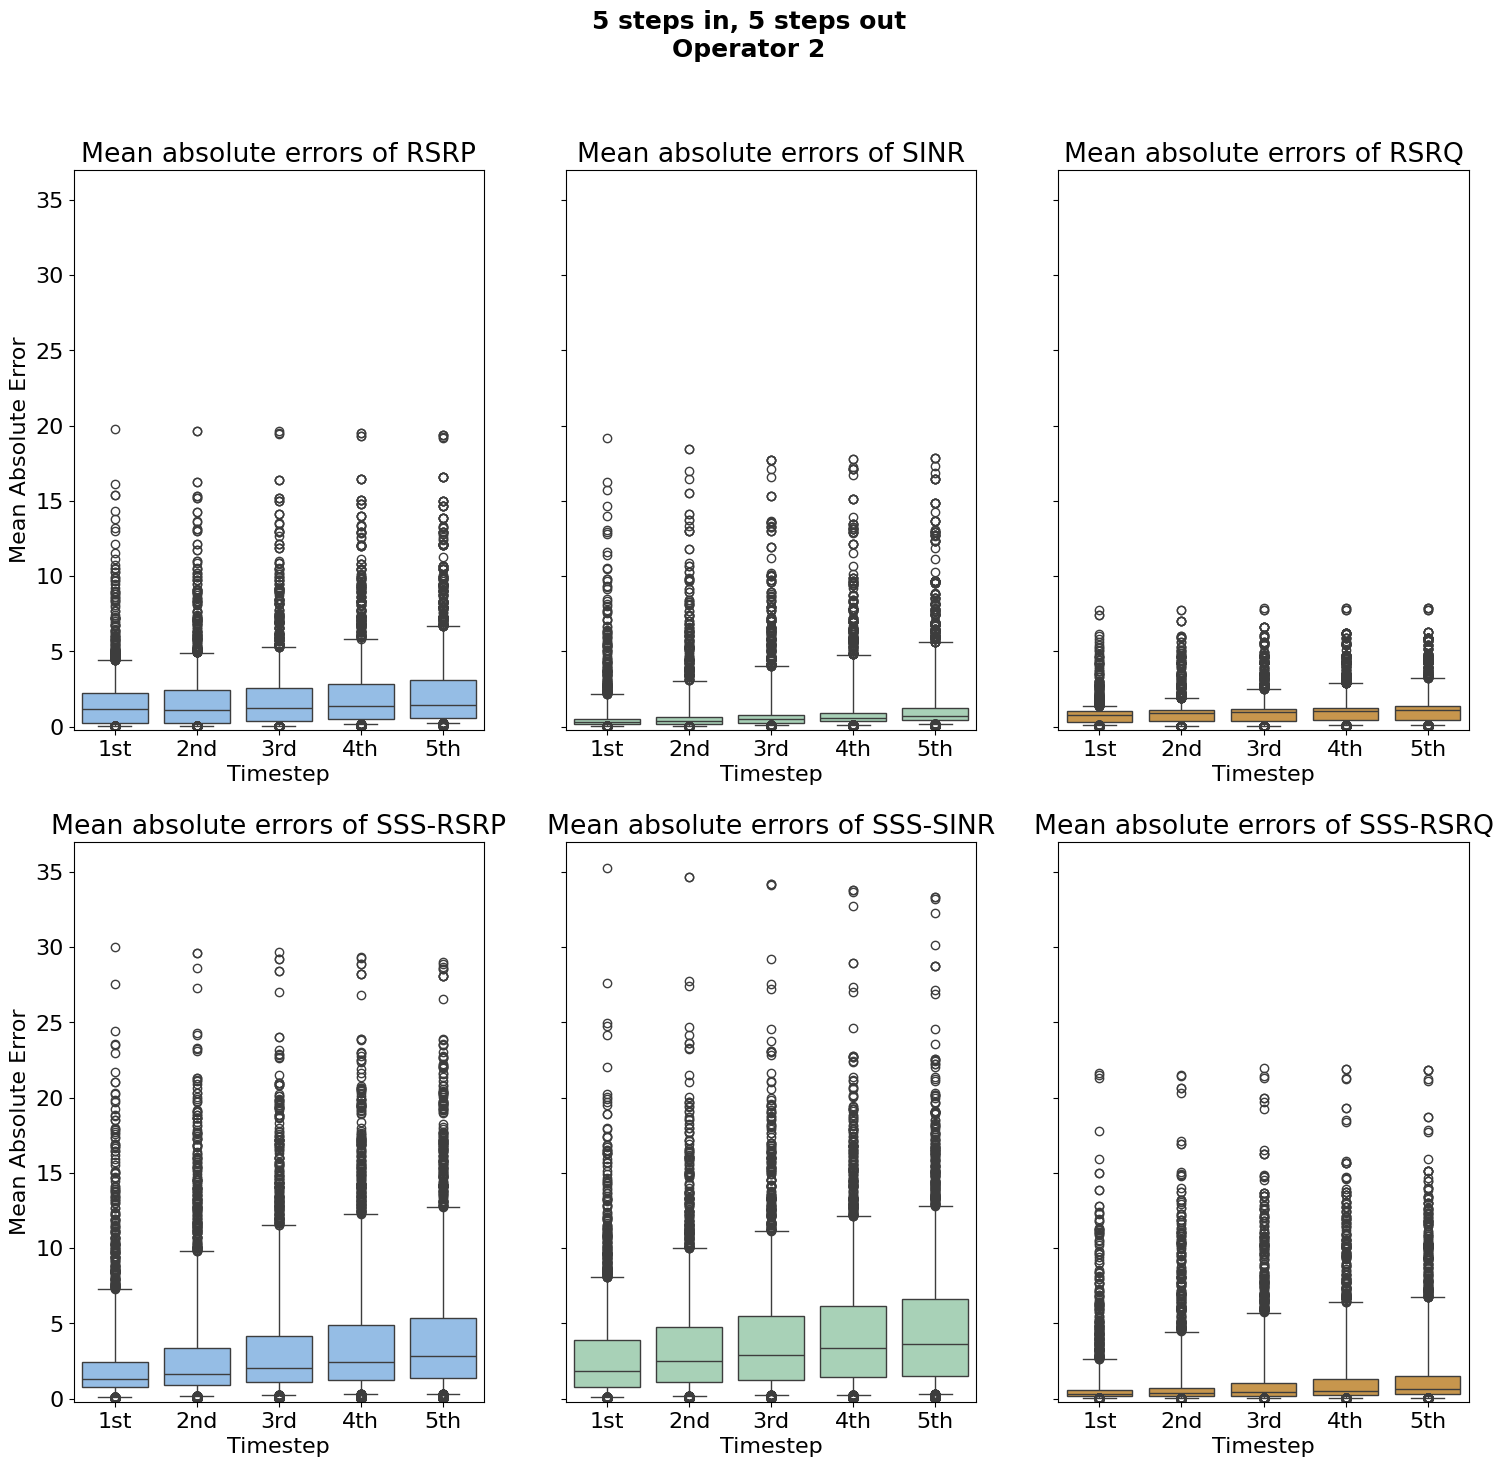

In [50]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op2_box_5_steps_mae_lstm_35_clusters.pdf')

In [51]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [52]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.642,0.876,0.541,0.999,0.999,0.998,0.598,0.564,0.774,0.853,0.821,0.861,"[0.6417787537743618, 0.6415042547351084, 0.641...","[0.9986474301172227, 0.9986474301172227, 0.998..."
1,"n_est: 5, min_leaf: 5",0.694,0.906,0.605,0.993,0.990,0.994,0.669,0.594,0.870,0.878,0.832,0.903,"[0.6933845731539939, 0.6936590721932473, 0.693...","[0.9926360084159904, 0.9926360084159904, 0.992..."
2,"n_est: 5, min_leaf: 10",0.627,0.838,0.548,0.987,0.984,0.989,0.625,0.550,0.834,0.878,0.844,0.892,"[0.627504803733187, 0.6272303046939336, 0.6269...","[0.9867748722572889, 0.9867748722572889, 0.986..."
3,"n_est: 5, min_leaf: 15",0.658,0.907,0.546,0.982,0.979,0.983,0.660,0.582,0.865,0.858,0.819,0.874,"[0.6579741970903101, 0.6579741970903101, 0.658...","[0.9818154493537722, 0.9818154493537722, 0.981..."
4,"n_est: 10, min_leaf: 1",0.683,0.915,0.581,0.999,0.999,0.999,0.636,0.531,0.877,0.878,0.811,0.921,"[0.6832281087016195, 0.6832281087016195, 0.683...","[0.9989480012022843, 0.9989480012022843, 0.998..."
5,"n_est: 10, min_leaf: 5",0.689,0.897,0.604,0.996,0.996,0.996,0.665,0.606,0.850,0.890,0.848,0.914,"[0.6889925885259401, 0.6887180894866868, 0.688...","[0.9963931469792606, 0.9963931469792606, 0.996..."
6,"n_est: 10, min_leaf: 10",0.689,0.913,0.592,0.992,0.991,0.991,0.659,0.577,0.869,0.894,0.847,0.922,"[0.6895415866044469, 0.6892670875651935, 0.689...","[0.9917342951608056, 0.9917342951608056, 0.991..."
7,"n_est: 10, min_leaf: 15",0.691,0.919,0.590,0.986,0.985,0.985,0.672,0.596,0.874,0.889,0.837,0.920,"[0.691188580839967, 0.6909140818007137, 0.6909...","[0.9861737300871656, 0.9861737300871656, 0.986..."
8,"n_est: 50, min_leaf: 1",0.665,0.906,0.557,0.999,0.999,0.999,0.642,0.560,0.856,0.903,0.860,0.929,"[0.6651111721108977, 0.6648366730716443, 0.664...","[0.9990982867448152, 0.9990982867448152, 0.999..."
9,"n_est: 50, min_leaf: 5",0.668,0.885,0.580,0.997,0.997,0.997,0.659,0.574,0.872,0.911,0.879,0.930,"[0.6686796596211914, 0.668405160581938, 0.6684...","[0.9969942891493838, 0.9969942891493838, 0.996..."


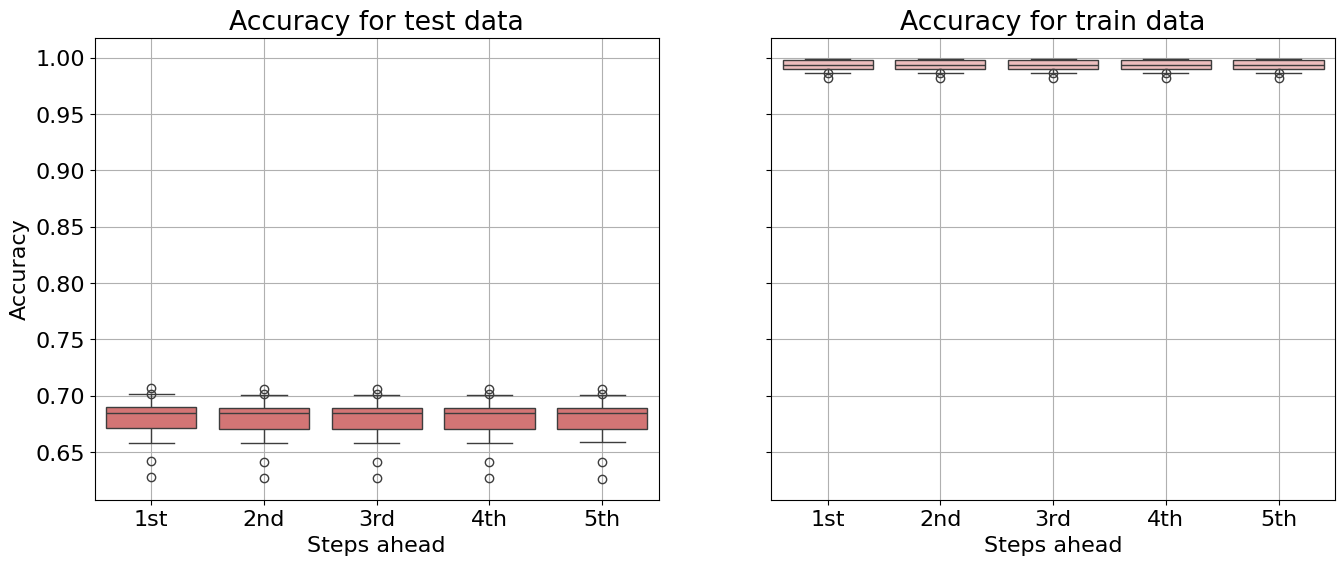

In [53]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/rf_loc/op2_boxplot_5_steps_35_clusters.pdf')

## 20 clusters

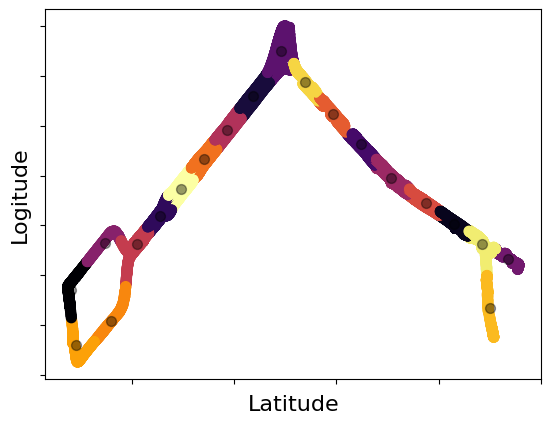

In [54]:
kmeans = KMeans(n_clusters=20, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op2_map_20_clusters_kmeans.pdf')

In [55]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,5
1,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,5
2,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,5
3,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,5
4,-107.06,4.83,-17.18,-116.8,-2.8,-15.0,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,5
...,...,...,...,...,...,...,...,...,...
10328,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,18
10329,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,18
10330,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,18
10331,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,18


In [56]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

### LSTM

#### 1 step ahead

In [57]:
units = [5, 10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [58]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [59]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00338,0.00169,2.10,1.81
1,"RSRP, SINR -> RSRP",0.00571,0.00218,2.59,2.18
2,"RSRP, RSRQ -> RSRP",0.00301,0.00349,2.54,2.49
3,"RSRP, SINR, RSRQ -> RSRP",0.00274,0.00259,2.02,2.07
4,"RSRP, SSS_RSRP -> RSRP",0.00239,0.00209,1.72,1.80
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00278,0.00388,2.29,2.67
6,SINR -> SINR,0.00265,0.00732,1.43,1.34
7,"RSRP, SINR -> SINR",0.00224,0.00147,0.74,0.77
8,"SINR, RSRQ -> SINR",0.00166,0.00274,1.53,1.33
9,"RSRP, SINR, RSRQ -> SINR",0.00227,0.00478,2.53,2.24


In [60]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

### Random Forest

In [61]:
n_est, leaf = 50, 5

In [62]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]
warnings.simplefilter(action='ignore')
rf_results[f'n_est: {n_est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=n_est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 50, min_leaf: 5",0.713,0.923,0.622,0.997,0.998,0.996,0.74,0.682,0.906,0.914,0.924,0.897,[],[]


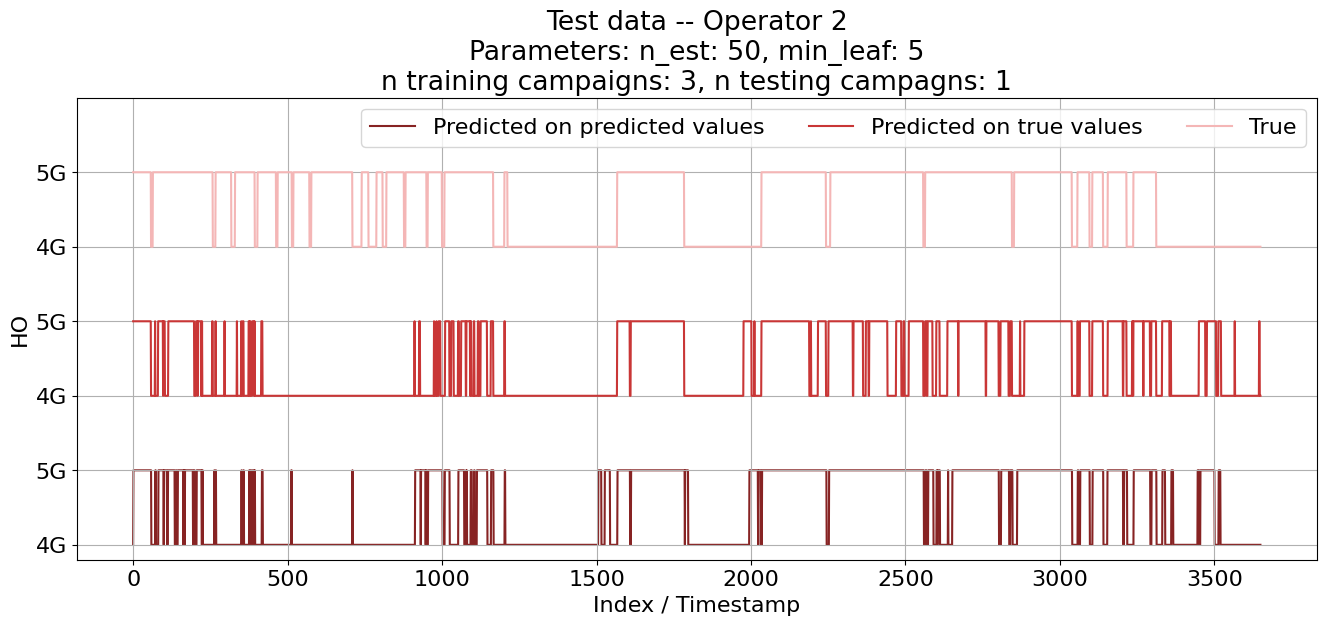

In [63]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

In [64]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [65]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.696,0.892,0.621,0.999,0.999,0.998,0.725,0.677,0.885,0.884,0.881,0.875,[],[]
1,"n_est: 5, min_leaf: 5",0.711,0.912,0.629,0.996,0.996,0.996,0.749,0.710,0.892,0.902,0.901,0.892,[],[]
2,"n_est: 5, min_leaf: 10",0.659,0.867,0.580,0.992,0.991,0.993,0.677,0.605,0.874,0.878,0.890,0.857,[],[]
3,"n_est: 5, min_leaf: 15",0.708,0.894,0.639,0.987,0.985,0.988,0.761,0.721,0.903,0.914,0.910,0.907,[],[]
4,"n_est: 10, min_leaf: 1",0.706,0.921,0.613,0.999,0.999,0.998,0.689,0.589,0.917,0.901,0.895,0.895,[],[]
5,"n_est: 10, min_leaf: 5",0.708,0.931,0.609,0.996,0.997,0.995,0.752,0.680,0.931,0.918,0.911,0.914,[],[]
6,"n_est: 10, min_leaf: 10",0.712,0.938,0.610,0.992,0.991,0.992,0.748,0.687,0.915,0.890,0.885,0.883,[],[]
7,"n_est: 10, min_leaf: 15",0.733,0.936,0.645,0.993,0.991,0.995,0.752,0.676,0.936,0.896,0.888,0.891,[],[]
8,"n_est: 50, min_leaf: 1",0.728,0.923,0.647,0.999,0.999,0.999,0.762,0.701,0.924,0.922,0.932,0.906,[],[]
9,"n_est: 50, min_leaf: 5",0.702,0.922,0.607,0.997,0.999,0.995,0.731,0.669,0.904,0.924,0.931,0.911,[],[]


In [66]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.718
Mean precision: 0.920
Mean recall: 0.632


#### 5 steps ahead

In [67]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [68]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00338,0.00169,2.10,1.81
1,"RSRP, SINR -> RSRP",0.00571,0.00218,2.59,2.18
2,"RSRP, RSRQ -> RSRP",0.00301,0.00349,2.54,2.49
3,"RSRP, SINR, RSRQ -> RSRP",0.00274,0.00259,2.02,2.07
4,"RSRP, SSS_RSRP -> RSRP",0.00239,0.00209,1.72,1.80
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00278,0.00388,2.29,2.67
6,SINR -> SINR,0.00265,0.00732,1.43,1.34
7,"RSRP, SINR -> SINR",0.00224,0.00147,0.74,0.77
8,"SINR, RSRQ -> SINR",0.00166,0.00274,1.53,1.33
9,"RSRP, SINR, RSRQ -> SINR",0.00227,0.00478,2.53,2.24


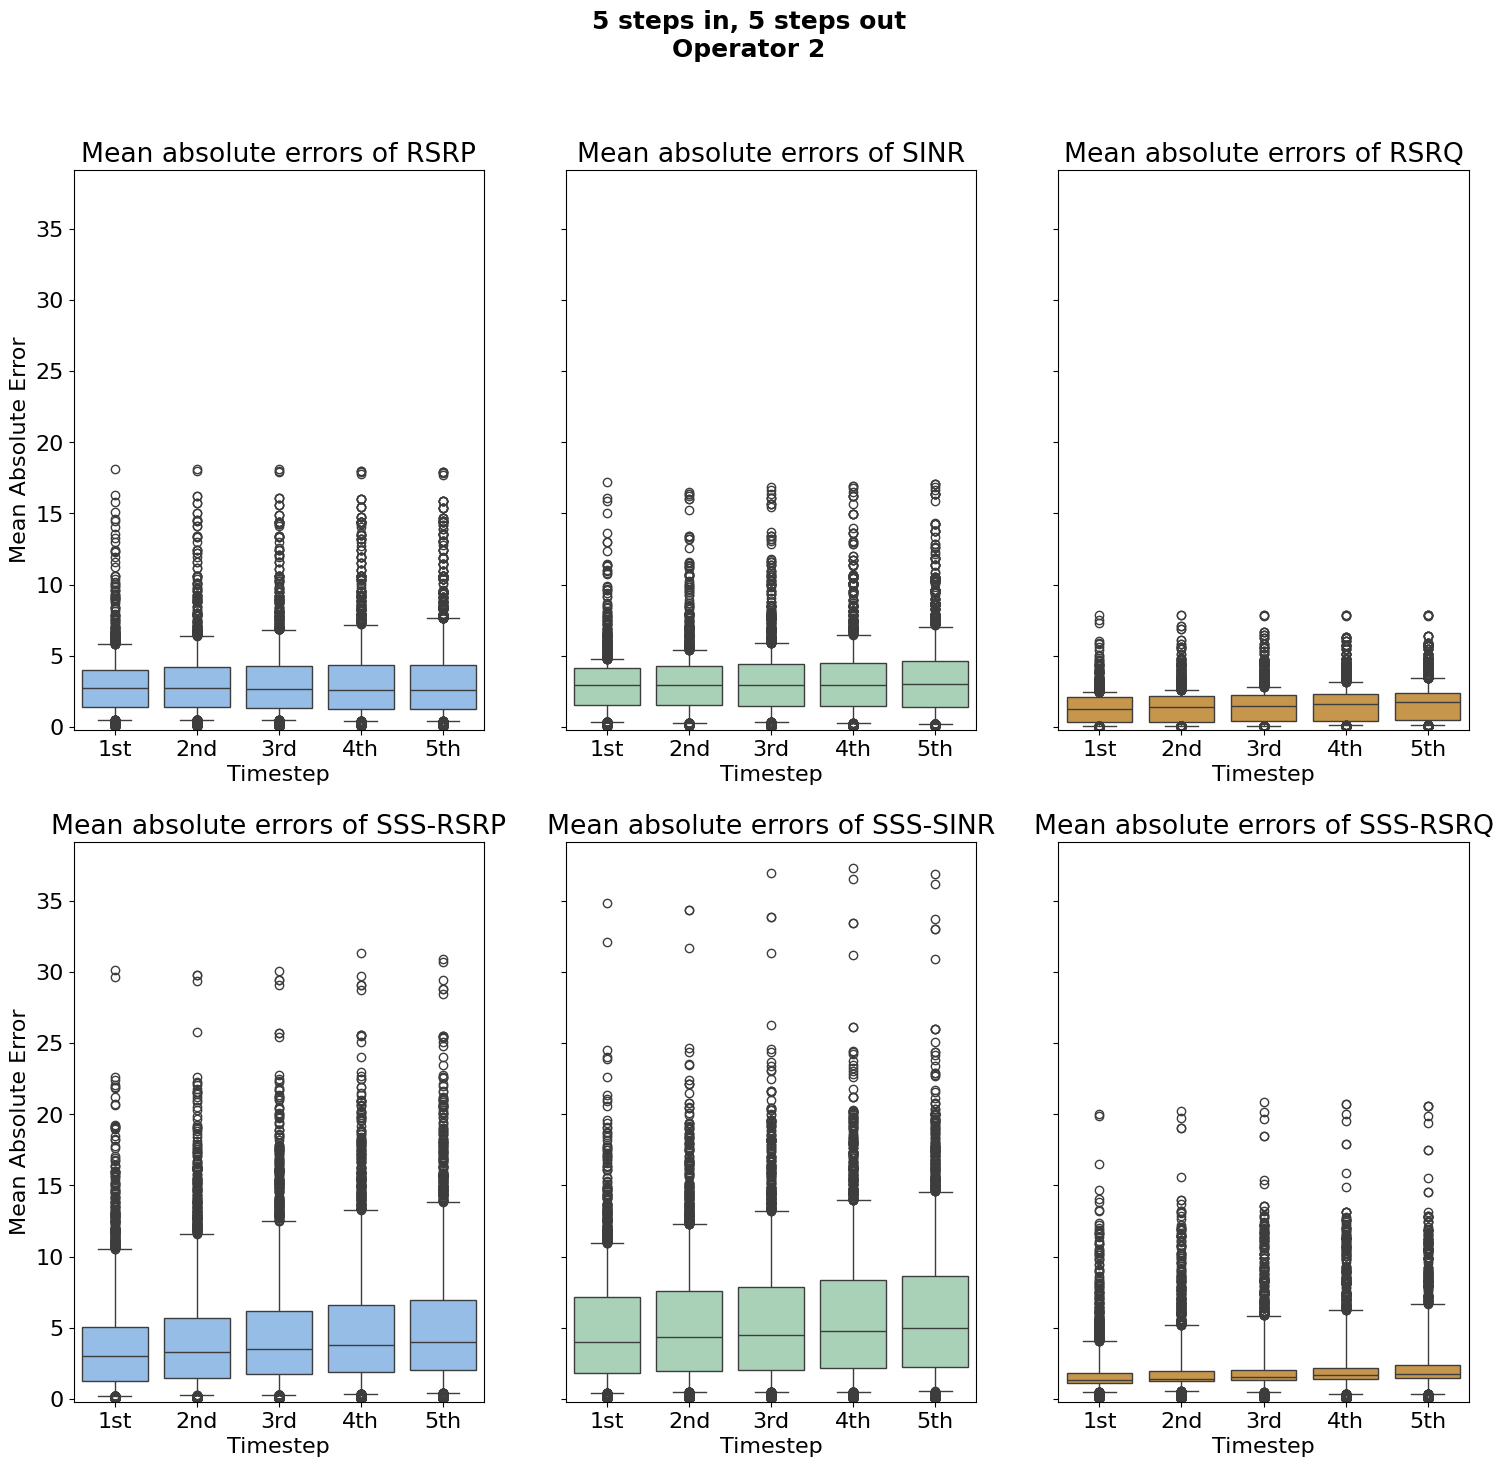

In [69]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op2_box_5_steps_mae_lstm_20_clusters.pdf')

In [70]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [71]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.680,0.891,0.594,0.999,0.999,0.998,0.673,0.680,0.802,0.787,0.900,0.720,"[0.6796596211913258, 0.6796596211913258, 0.679...","[0.9987977156597535, 0.9987977156597535, 0.998..."
1,"n_est: 5, min_leaf: 5",0.715,0.920,0.630,0.995,0.995,0.994,0.694,0.681,0.832,0.831,0.898,0.778,"[0.7156189953335164, 0.715344496294263, 0.7153...","[0.9947400060114217, 0.9947400060114217, 0.994..."
2,"n_est: 5, min_leaf: 10",0.690,0.900,0.604,0.992,0.992,0.991,0.663,0.659,0.802,0.815,0.887,0.761,"[0.6900905846829536, 0.6900905846829536, 0.690...","[0.9920348662458671, 0.9920348662458671, 0.992..."
3,"n_est: 5, min_leaf: 15",0.666,0.902,0.563,0.986,0.980,0.991,0.681,0.661,0.828,0.841,0.907,0.789,"[0.6664836673071645, 0.6664836673071645, 0.666...","[0.9861737300871656, 0.9861737300871656, 0.986..."
4,"n_est: 10, min_leaf: 1",0.699,0.928,0.597,0.999,0.999,0.999,0.686,0.688,0.815,0.841,0.884,0.801,"[0.6996980510568213, 0.6994235520175679, 0.699...","[0.9989480012022843, 0.9989480012022843, 0.998..."
5,"n_est: 10, min_leaf: 5",0.713,0.921,0.626,0.997,0.998,0.996,0.680,0.657,0.830,0.840,0.918,0.781,"[0.7131485039802361, 0.7131485039802361, 0.713...","[0.9969942891493838, 0.9969942891493838, 0.996..."
6,"n_est: 10, min_leaf: 10",0.747,0.934,0.669,0.992,0.989,0.994,0.747,0.754,0.851,0.844,0.933,0.781,"[0.7466373867691463, 0.7466373867691463, 0.746...","[0.9918845807033363, 0.9918845807033363, 0.991..."
7,"n_est: 10, min_leaf: 15",0.704,0.927,0.605,0.992,0.992,0.991,0.709,0.674,0.861,0.826,0.911,0.766,"[0.704090035684875, 0.704090035684875, 0.70409...","[0.9917342951608056, 0.9917342951608056, 0.991..."
8,"n_est: 50, min_leaf: 1",0.711,0.933,0.612,0.999,0.999,0.999,0.689,0.677,0.826,0.835,0.928,0.771,"[0.7112270107054626, 0.7112270107054626, 0.711...","[0.9990982867448152, 0.9990982867448152, 0.999..."
9,"n_est: 50, min_leaf: 5",0.726,0.926,0.642,0.997,0.998,0.996,0.710,0.705,0.836,0.838,0.922,0.777,"[0.7263244578643975, 0.7260499588251441, 0.726...","[0.9972948602344455, 0.9972948602344455, 0.997..."


In [72]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.714
Mean precision: 0.921
Mean recall: 0.627


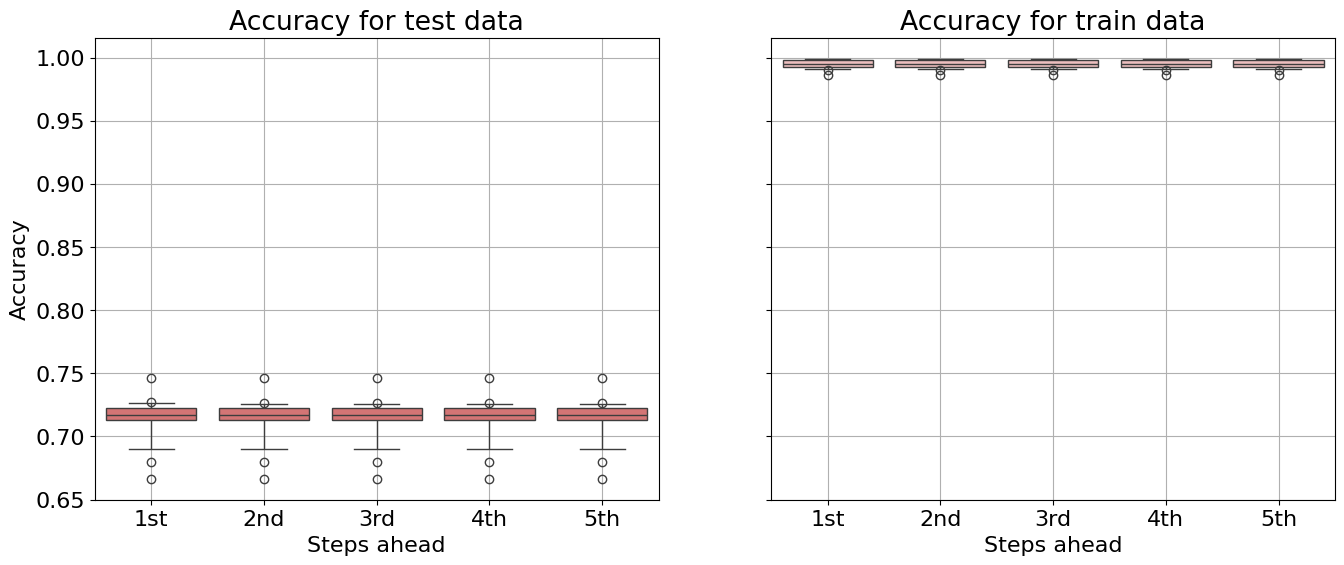

In [73]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_5_steps_20_clusters.pdf')

## 60 clusters

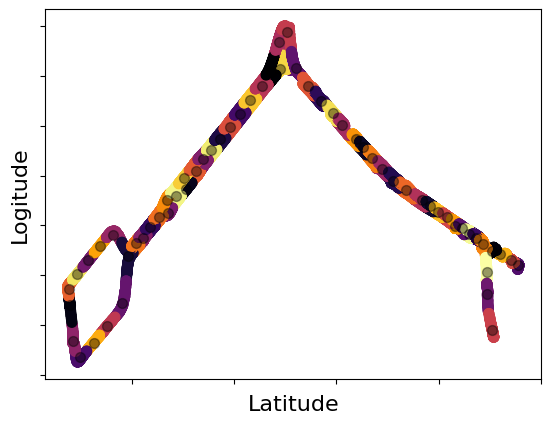

In [74]:
kmeans = KMeans(n_clusters=60, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

fig, ax = plt.subplots()
ax.scatter(x = X['Latitude'], y = X['Longitude'], c=labels, s=50, cmap='inferno')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.4)
ax.set_xlabel('Latitude')
ax.set_ylabel('Logitude')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()
fig = ax.get_figure()
fig.savefig(r'../latex/plots/rf_loc/op2_map_60_clusters_kmeans.pdf')

In [75]:
clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

,RSRP,SINR,RSRQ,SSS_RSRP,SSS_SINR,SSS_RSRQ,campaign,Mode,k_area
0,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,31
1,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,31
2,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,31
3,-109.13,4.79,-19.73,-112.1,3.3,-12.6,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,31
4,-107.06,4.83,-17.18,-116.8,-2.8,-15.0,Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...,1,31
...,...,...,...,...,...,...,...,...,...
10328,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,43
10329,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,43
10330,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,43
10331,-93.82,3.00,-17.38,-118.2,-1.6,-15.0,Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...,0,43


In [76]:
train = clustered_df[clustered_df['campaign'].isin(overlap[1::])]
test = clustered_df[clustered_df['campaign'] == overlap[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

### LSTM

#### 1 step ahead

In [77]:
units = [5, 10, 10]

target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]
for feat in feature_selection:
    feat.append('k_area')

In [78]:
n_steps_in, n_steps_out = 2, 1
lstm_results_1_step = {}
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00367,0.00092,1.54,1.35
1,"RSRP, SINR, RSRQ -> RSRP",0.00277,0.00140,1.52,1.43
2,"RSRP, SSS_RSRP -> RSRP",0.00306,0.00184,1.65,1.55
3,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00319,0.00335,2.24,2.25
4,SINR -> SINR,0.00238,0.00701,1.39,1.23
5,"RSRP, SINR, RSRQ -> SINR",0.00241,0.00813,2.35,2.09
6,"SINR, SSS_SINR -> SINR",0.00189,0.00211,1.47,1.21
7,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00235,0.00781,2.28,1.87
8,RSRQ -> RSRQ,0.00459,0.00360,0.37,0.37
9,"RSRP, SINR, RSRQ -> RSRQ",0.00373,0.00447,0.98,0.85


In [79]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['y_pred'].tolist(),
                                  'SINR': lstm_results_1_step[feature_comb[1]]['y_pred'].tolist(),
                                  'RSRQ': lstm_results_1_step[feature_comb[2]]['y_pred'].tolist(),
                                  'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['y_pred'].tolist(),
                                  'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['y_pred'].tolist(),
                                  'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['y_pred'].tolist(),
                                  'k_area': lstm_results_1_step[feature_comb[0]]['k_area'].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_1_step[feature_comb[0]]['train_pred'].tolist(),
                                       'SINR': lstm_results_1_step[feature_comb[1]]['train_pred'].tolist(),
                                       'RSRQ': lstm_results_1_step[feature_comb[2]]['train_pred'].tolist(),
                                       'SSS_RSRP': lstm_results_1_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                       'SSS_SINR': lstm_results_1_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                       'SSS_RSRQ': lstm_results_1_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                       'k_area': lstm_results_1_step[feature_comb[0]]['k_area_train'].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [80]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

In [81]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.641,0.837,0.575,0.999,0.999,0.998,0.693,0.689,0.824,0.883,0.909,0.853,[],[]
1,"n_est: 5, min_leaf: 5",0.646,0.820,0.603,0.995,0.996,0.993,0.653,0.605,0.831,0.885,0.876,0.879,[],[]
2,"n_est: 5, min_leaf: 10",0.666,0.830,0.630,0.993,0.995,0.989,0.673,0.669,0.809,0.861,0.893,0.826,[],[]
3,"n_est: 5, min_leaf: 15",0.682,0.895,0.596,0.986,0.984,0.987,0.685,0.632,0.860,0.877,0.904,0.846,[],[]
4,"n_est: 10, min_leaf: 1",0.662,0.884,0.570,0.999,0.999,0.998,0.678,0.605,0.876,0.902,0.909,0.886,[],[]
5,"n_est: 10, min_leaf: 5",0.663,0.855,0.598,0.997,0.998,0.994,0.673,0.622,0.848,0.898,0.906,0.881,[],[]
6,"n_est: 10, min_leaf: 10",0.682,0.876,0.612,0.991,0.990,0.991,0.696,0.648,0.865,0.904,0.922,0.879,[],[]
7,"n_est: 10, min_leaf: 15",0.673,0.886,0.587,0.986,0.989,0.981,0.689,0.626,0.874,0.876,0.912,0.839,[],[]
8,"n_est: 50, min_leaf: 1",0.686,0.884,0.611,0.999,0.999,0.999,0.698,0.641,0.874,0.910,0.914,0.897,[],[]
9,"n_est: 50, min_leaf: 5",0.685,0.877,0.616,0.997,0.998,0.997,0.698,0.649,0.867,0.911,0.930,0.887,[],[]


In [82]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.677
Mean precision: 0.878
Mean recall: 0.602


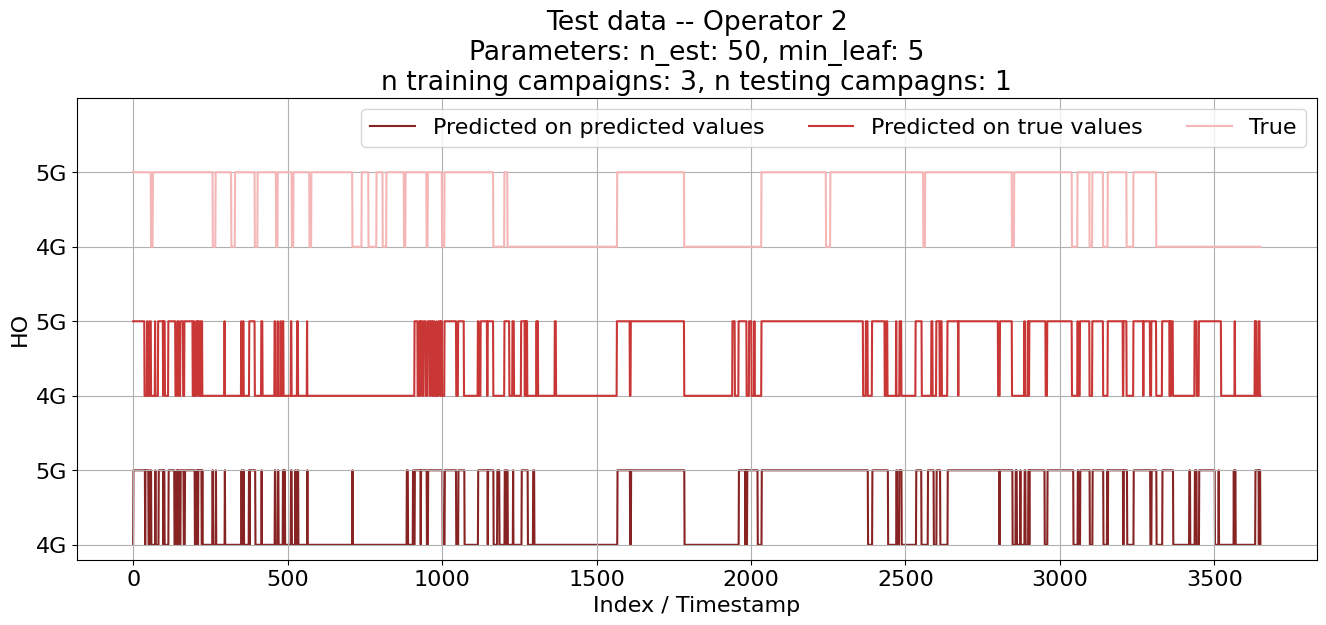

In [83]:
comb = 'n_est: 50, min_leaf: 5'
combination = rf_results[comb]
y_true = combination['y_true']
y_pred = combination['y_pred']
pred_pred = combination['pred_pred']
fig = plot_mode(pred=y_pred, true=y_true, preds=pred_pred, operator=operator, comb=comb, campaigns=campaigns, test_campaigns=test_campaigns)

#### 5 steps ahead

In [84]:
n_steps_in, n_steps_out = 5, 5
lstm_results_5_step = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            feat = features.copy()
            feat.remove('k_area')
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(feat)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_5_step[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_lstm_results = pd.DataFrame.from_dict(lstm_results_1_step, orient='index')
df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'loss', 'val_loss', 'list_mae', 'train_list_mae', 'k_area', 'k_area_train'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,RSRP -> RSRP,0.00367,0.00092,1.54,1.35
1,"RSRP, SINR, RSRQ -> RSRP",0.00277,0.00140,1.52,1.43
2,"RSRP, SSS_RSRP -> RSRP",0.00306,0.00184,1.65,1.55
3,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00319,0.00335,2.24,2.25
4,SINR -> SINR,0.00238,0.00701,1.39,1.23
5,"RSRP, SINR, RSRQ -> SINR",0.00241,0.00813,2.35,2.09
6,"SINR, SSS_SINR -> SINR",0.00189,0.00211,1.47,1.21
7,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...",0.00235,0.00781,2.28,1.87
8,RSRQ -> RSRQ,0.00459,0.00360,0.37,0.37
9,"RSRP, SINR, RSRQ -> RSRQ",0.00373,0.00447,0.98,0.85


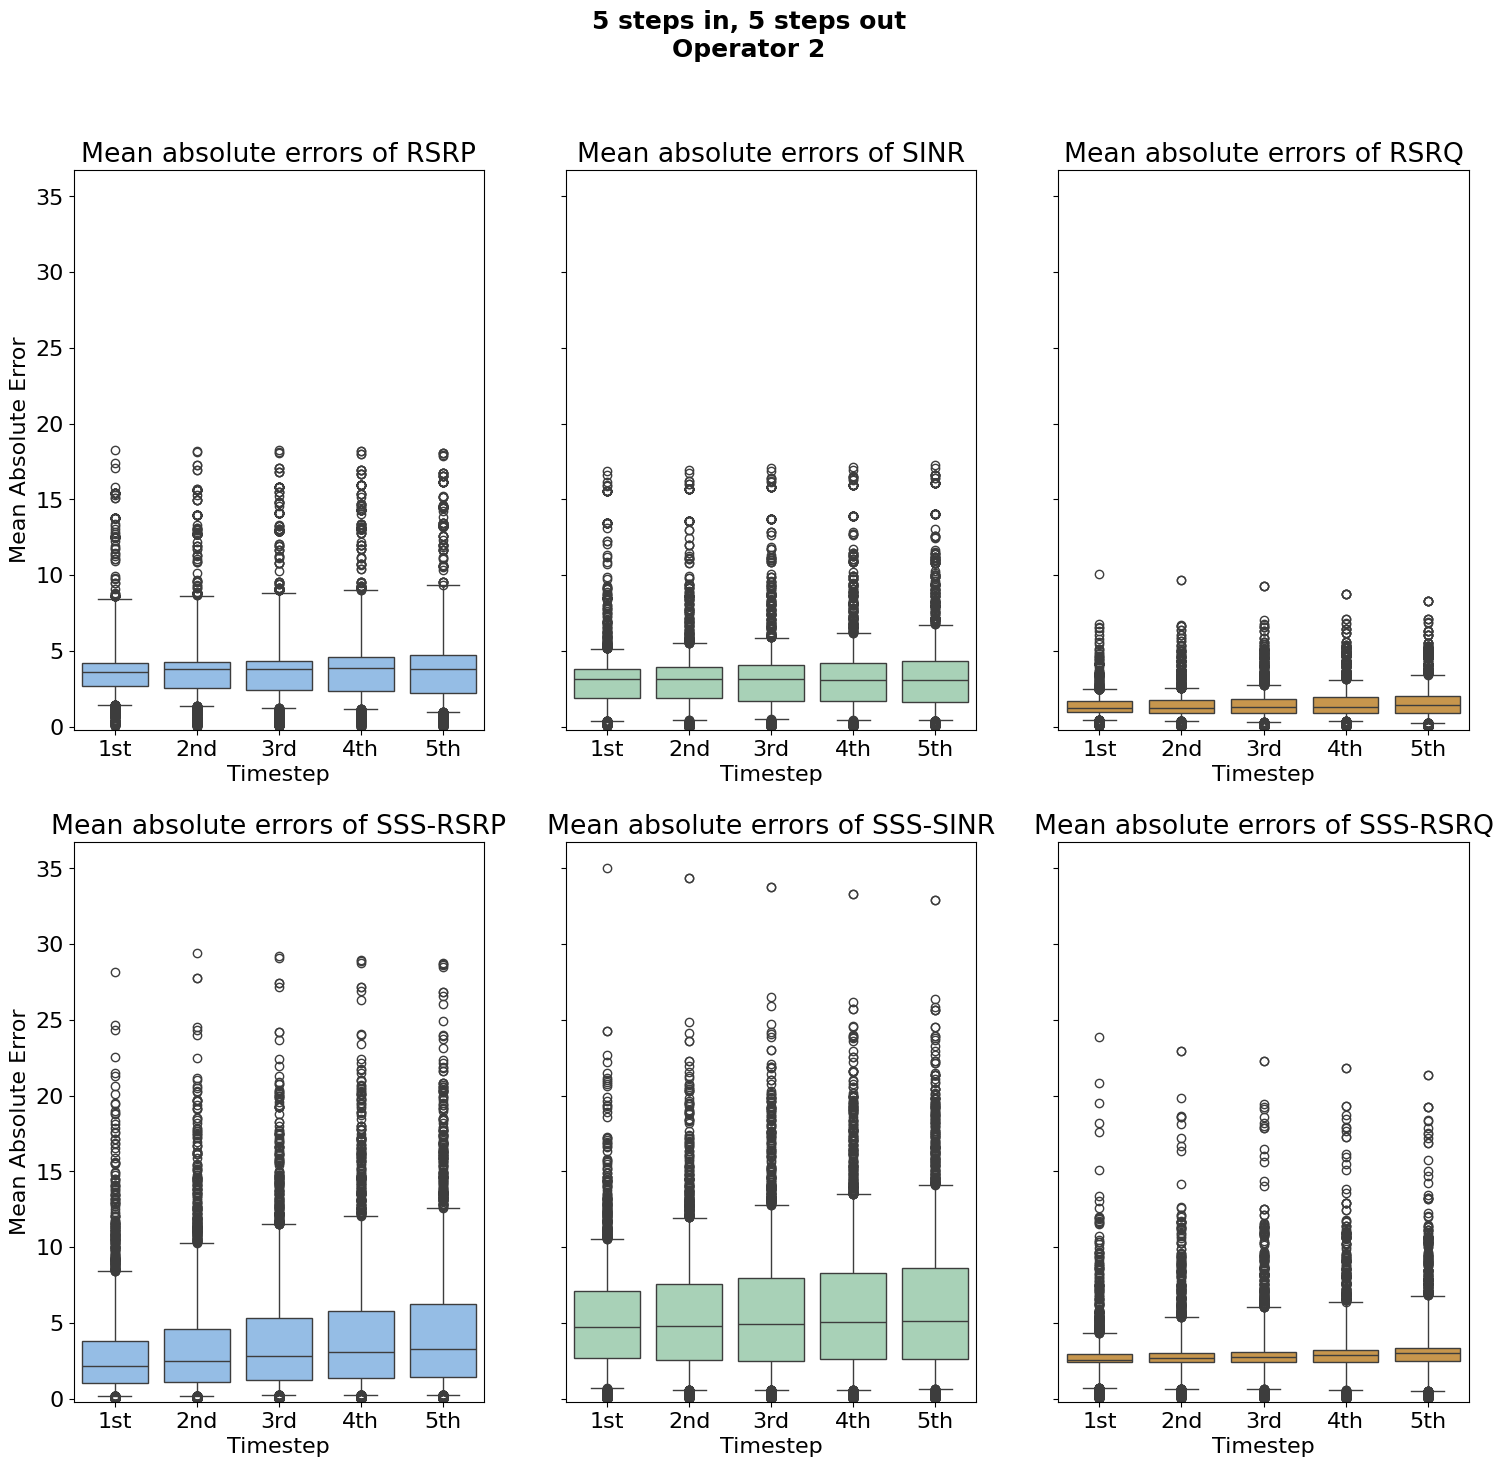

In [85]:
fig, mae_each_step = boxplot_timesteps(results=lstm_results_5_step, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_in=n_steps_in, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/rf_loc/op2_box_5_steps_mae_lstm_60_clusters.pdf')

In [86]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['y_pred'].tolist(),
                           'SINR': lstm_results_5_step[feature_comb[1]]['y_pred'].tolist(),
                           'RSRQ': lstm_results_5_step[feature_comb[2]]['y_pred'].tolist(),
                           'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['y_pred'].tolist(),
                           'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['y_pred'].tolist(),
                           'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['y_pred'].tolist(),
                           'k_area': lstm_results_5_step[feature_comb[0]]['k_area'].tolist()},
                           columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train = pd.DataFrame({'RSRP': lstm_results_5_step[feature_comb[0]]['train_pred'].tolist(),
                                'SINR': lstm_results_5_step[feature_comb[1]]['train_pred'].tolist(),
                                'RSRQ': lstm_results_5_step[feature_comb[2]]['train_pred'].tolist(),
                                'SSS_RSRP': lstm_results_5_step[sss_feature_comb[0]]['train_pred'].tolist(),
                                'SSS_SINR': lstm_results_5_step[sss_feature_comb[1]]['train_pred'].tolist(),
                                'SSS_RSRQ': lstm_results_5_step[sss_feature_comb[2]]['train_pred'].tolist(),
                                'k_area': lstm_results_5_step[feature_comb[0]]['k_area_train'].tolist()},
                                columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

In [87]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign'])
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, preds=lstm_preds, train_preds__=lstm_pred_train)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train,Accuracy_pred,Precision_pred,Recall_pred,Accuracy_train_pred,Recall_train_pred,Precision_train_pred,Accuracy_list,Accuracy_train_list
0,"n_est: 5, min_leaf: 1",0.623,0.813,0.567,0.999,0.999,0.999,0.627,0.712,0.725,0.729,0.873,0.661,"[0.6225638210266264, 0.6228383200658798, 0.623...","[0.9989480012022843, 0.9989480012022843, 0.998..."
1,"n_est: 5, min_leaf: 5",0.690,0.849,0.653,0.993,0.993,0.993,0.621,0.630,0.763,0.743,0.851,0.683,"[0.6909140818007137, 0.6906395827614603, 0.690...","[0.9933874361286444, 0.9933874361286444, 0.993..."
2,"n_est: 5, min_leaf: 10",0.630,0.818,0.575,0.989,0.986,0.991,0.629,0.727,0.721,0.761,0.948,0.676,"[0.6299752950864672, 0.6299752950864672, 0.629...","[0.9893297264803126, 0.9893297264803126, 0.989..."
3,"n_est: 5, min_leaf: 15",0.679,0.878,0.605,0.982,0.979,0.983,0.630,0.704,0.732,0.732,0.909,0.657,"[0.6796596211913258, 0.6793851221520725, 0.679...","[0.9821160204388338, 0.9821160204388338, 0.982..."
4,"n_est: 10, min_leaf: 1",0.690,0.940,0.573,0.999,0.999,0.999,0.638,0.633,0.784,0.767,0.885,0.701,"[0.690365083722207, 0.6900905846829536, 0.6900...","[0.9990982867448152, 0.9990982867448152, 0.999..."
5,"n_est: 10, min_leaf: 5",0.700,0.877,0.642,0.997,0.997,0.996,0.645,0.667,0.771,0.791,0.918,0.718,"[0.7005215481745813, 0.700247049135328, 0.7002...","[0.9966937180643222, 0.9966937180643222, 0.996..."
6,"n_est: 10, min_leaf: 10",0.688,0.881,0.617,0.993,0.994,0.990,0.667,0.671,0.799,0.773,0.924,0.696,"[0.6881690914081801, 0.6878945923689267, 0.687...","[0.9927862939585211, 0.9927862939585211, 0.992..."
7,"n_est: 10, min_leaf: 15",0.691,0.867,0.635,0.988,0.988,0.986,0.633,0.658,0.761,0.792,0.912,0.721,"[0.6909140818007137, 0.6909140818007137, 0.690...","[0.9878268710550046, 0.9878268710550046, 0.987..."
8,"n_est: 50, min_leaf: 1",0.690,0.893,0.609,0.999,0.999,0.999,0.649,0.710,0.752,0.776,0.933,0.696,"[0.6898160856437002, 0.6895415866044469, 0.689...","[0.9990982867448152, 0.9990982867448152, 0.999..."
9,"n_est: 50, min_leaf: 5",0.694,0.908,0.604,0.997,0.999,0.996,0.635,0.703,0.739,0.759,0.905,0.686,"[0.6944825693110074, 0.694208070271754, 0.6942...","[0.9974451457769763, 0.9974451457769763, 0.997..."


In [88]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.683
Mean precision: 0.882
Mean recall: 0.608


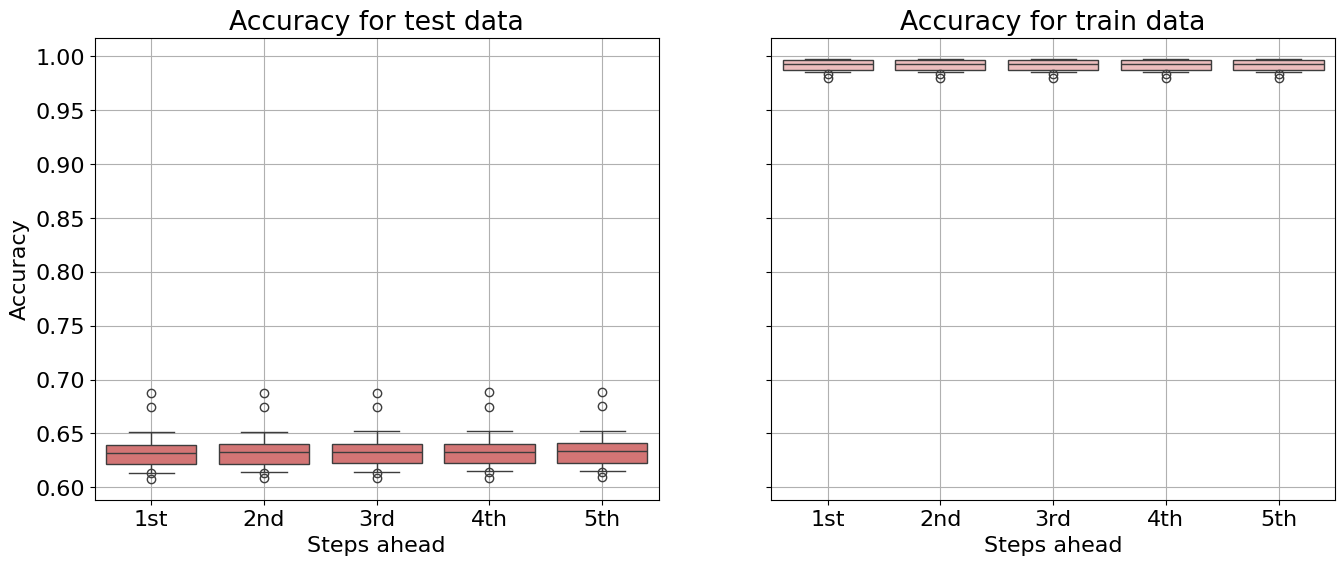

In [ ]:
fig = boxplot_accuracies(results=rf_results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/rf_loc/op2_boxplot_5_steps_60_clusters.pdf')